# <center> Bài toán tìm xác xuất hoàn thành dự án </center>

Mục đích của bài toán là tìm giá trị trung bình ($\mu$) và phương sai ($\sigma$) cho phân bố chuẩn xác suất hoàn thành dự án theo thời gian. Từ đó tìm được xác suất hoàn thành dự án trong thời gian muốn biết. 

**Ví dụ cho bảng ví dụ sau, tìm xác suất để hoàn thành dự án trong 34 ngày.** ([Youtube](https://www.youtube.com/watch?v=LryrWD-Ud8E&list=PLxwxUPrl6ShJVjr0Onsy1Hy2mx3hBBR1Z&index=5))

In [28]:
import pandas as pd

db = pd.read_csv("vd.csv", sep = "\t")
print(db)

  Activity  Optimistic (a)  Most Likely (m)  Pessimistic (b) Predecessors
0        A               3                4               11            -
1        B               2                5                8            A
2        C               3                6                9            A
3        D              10               13               22          B,C
4        E               4                5               12            B
5        F               1                4                7            D
6        G               6                8               16            C
7        H               1                2                3        E,F,G


<u>Chú thích:</u>
- Cột 1: Tên các công việc trong dự án
- Cột 2: Thời gian lạc quan (a), thời gian sớm nhất công việc có thể hoàn thành
- Cột 3: Thời gian dễ xảy ra nhất (m), thời gian để hoàn thành công việc có xác suất cao nhất
- Cột 4: Thời gian bi quan (b), thời gian trễ nhất để hoàn thành công việc
- Cột 5: Công việc liền trước

## **<center> Giải </center>**

### Bước 1: Tính thời gian mong đợi hoàn thành công việc (Expected time)

Sử dụng công thức: $$TE=\frac{a+4m+b}{6}$$
<u>Với:</u>
- TE là thời gian mong đợi
- a là thời gian lạc quan
- b là thời gian dễ xảy ra nhất
- c là thời gian bi quan

In [29]:
## Khai bao bien du lieu
a_vals = list(db.iloc[:,1])
m_vals = list(db.iloc[:,2])
b_vals = list(db.iloc[:,3])
tenac = list(db.iloc[:,0])
prede = list(db.iloc[:,-1])
#print(a_vals)

## Tinh TE 
te_vals = [(a_vals[i]+4*m_vals[i]+b_vals[i])/6 for i in range(len(a_vals))]
print(te_vals)

[5.0, 5.0, 6.0, 14.0, 6.0, 4.0, 9.0, 2.0]


### Bước 2: Tính phương sai (Variance) 

Tính phương sai theo công thức: $$ \sigma^2 = \frac{(b-a)^2}{36} $$


<u>Với:</u> 
- $\sigma$ là độ lệch chuẩn, phương sai bằng $\sigma^2$
- a là thời gian lạc quan
- b là thời gian bi quan 

In [30]:
ps = [(b_vals[i]-a_vals[i])**2/36 for i in range(len(b_vals))] # phuong sai
print(ps)

[1.7777777777777777, 1.0, 1.0, 4.0, 1.7777777777777777, 1.0, 2.7777777777777777, 0.1111111111111111]


### Bước 3: Vẽ Gantt chart và xác định đường Gantt

Vẽ Gantt Chart dựa trên Predecessors và xác định đường Gantt dựa trên TE (tổng TE lớn nhất):
- Xác định các con đường 

In [31]:
import networkx as nx
def tim_vector(tenda,pretenda): # Tim cac vector tren giang do
	Start_point = [i for i in tenda if pretenda[tenda.index(i)] == '-'] #Tìm start point
	#print(Start_point)

	# Liệt kê các vector:
	##Thêm vector start point
	vector = [["Start",i] for i in Start_point] 
	#print(vector)

	##Thêm vector trung gian
	for i in range(len(pretenda)): 
	    if pretenda[i] != "-" and len(pretenda[i]) == 1:
	        vector.append([pretenda[i],tenda[i]])
	    elif len(pretenda[i]) > 1:
	        Stats = pretenda[i].split(",")
	        for k in range(len(Stats)):
	            vector.append([Stats[k],tenda[i]]) 
	#print(vector)

	##Tìm end point
	End_point = []
	for i in range(len(tenda)):
	    a = 0
	    for k in range(len(pretenda)):
	        if tenda[i] in pretenda[k]:
	            a += 1
	    if a == 0:
	        End_point.append(tenda[i])
	#print(End_point)

	vector.extend([[i,'End'] for i in End_point])
	#print(vector)
	return vector

def all_paths(G): # Xuat ra cac con duong
    roots = (v for v, d in G.in_degree() if d == 0)
    leaves = [v for v, d in G.out_degree() if d == 0]
    all_paths = []
    for root in roots:
        paths = nx.all_simple_paths(G, root, leaves)
        all_paths.extend(paths)
    return all_paths

def pathsf(tenda,pretenda): # Xac dinh cac con duong
	# Xac dinh cac con duong
	## Xac dinh cac vecto
	vector = tim_vector(tenda,pretenda)
	#print(vector)
	## Xac dinh cac con duong
	G = nx.DiGraph()
	G.add_edges_from(vector)
	paths = all_paths(G)
	#print(lisotoString(paths))
	return paths


In [32]:
paths =  pathsf(tenac,prede)
print(paths)

[['Start', 'A', 'B', 'D', 'F', 'H', 'End'], ['Start', 'A', 'B', 'E', 'H', 'End'], ['Start', 'A', 'C', 'D', 'F', 'H', 'End'], ['Start', 'A', 'C', 'G', 'H', 'End']]


- Tính Tổng TE của các con đường và tìm index đường Gantt (tổng TE lớn nhất)

In [33]:
def Tim_gantt(paths,tenda,tg1): # Rà thời gian thực hiện dự án của các con đường 
    g_list = []
    for i in range(len(paths)):
        g_val = []
        for k in range(1,len(paths[i])-1):
            for j in range(len(tenda)):
                if tenda[j] == paths[i][k]:
                    g_val.append(tg1[j])
        g_list.append(g_val)
    return g_list

class Ganttc(): 
	def __init__(self,tenda,paths,tg1):
		self.tenda = tenda
		self.paths = paths
		self.tg1 = tg1
		self.g_list = Tim_gantt(self.paths,self.tenda,self.tg1)
    #print(g_list)

	def time(self): # Tra ve thoi gian hoan thanh du an    
		return [sum(i) for i in self.g_list]
    	#print("Thời gian hoàn thành: "+ str(g_val_list))

	def gantt(self): # Tra ve duong gantt
	    max_tg = max(self.time())
	    #print(max_tg)

	    Gantt = [self.time().index(max_tg)]
	    return Gantt

In [34]:
Gantt = Ganttc(tenac,paths,te_vals)

te_paths = Gantt.time()
print(te_paths)

index_gantt = Gantt.gantt()
print(index_gantt)

[30.0, 18.0, 31.0, 22.0]
[2]


### Bước 4: Tính các giá trị thông số của network để xác định $\mu$ và $\Sigma\sigma^2$ trên đường Gantt 

    - EST (earliest start time): thời gian bắt đầu dự án sớm nhất
    - EFT (earliest finish time): thời gian kết thúc dự án sớm nhất
    - LST (latest start time): thời gian bắt đầu dự án muộn nhất
    - LFT (latest finish time): thời gian kết thúc dự án muộn nhất

![Sơ đồ](20221202113044.png)  


In [35]:
# Tạo hàm tính EST và EFT
def Find_pp(paths,nameac): # Tim cac diem lien ke truoc cua 1 diem tron cac con duong
    beforeac = [sublist[i-1] for sublist in paths for i in range(len(sublist)) if sublist[i] == nameac] # Lay cac ac nam truoc nameac trong cac con duong
    #print(beforeac)
    beforeac_uniq = []
    tem = [beforeac_uniq.append(i) for i in beforeac if i not in beforeac_uniq] # Chon loc duy nhat
    #print(beforeac_uniq)
    return beforeac_uniq
#print(Find_pp(paths,nameac))

def Find_est(tenac,te_vals,paths): # Tìm est vaf eft cua cac cong viec
    est_lib = {tenac[i]:[0,te_vals[i]] for i in range(len(tenac))} # Tao thu vien est
    #print(est_lib)

    for path in paths:
        for i in range(2,len(path)-1): # Tinh cac 1 input truoc
            pp = Find_pp(paths,path[i])
            #print(pp)
            if len(pp) == 1:
                est_lib[path[i]][0] = est_lib[pp[0]][0]+est_lib[pp[0]][1]
        
        for i in range(2,len(path)-1): # Tinh cac hai input tro len
            pp = Find_pp(paths,path[i])
            #print(pp)
            if len(pp) > 1:
                est_lib[path[i]][0] = max([est_lib[k][0]+est_lib[k][1] for k in pp])
        
        for i in range(2,len(path)-1): # Tinh laij cac 1 in put
            pp = Find_pp(paths,path[i])
            #print(pp)
            if len(pp) == 1:
                est_lib[path[i]][0] = est_lib[pp[0]][0]+est_lib[pp[0]][1]

    #print(est_lib)
    est_vals = [est_lib[i][0] for i in est_lib]
    eft_vals = [sum(est_lib[i]) for i in est_lib]
    #print(est_vals)
    return est_vals, eft_vals

est_vals, eft_vals = Find_est(tenac,te_vals,paths)
print(est_vals) # Gia tri est
print(eft_vals) # Gia tri eft


[0, 5.0, 5.0, 11.0, 10.0, 25.0, 11.0, 29.0]
[5.0, 10.0, 11.0, 25.0, 16.0, 29.0, 20.0, 31.0]


In [36]:
# Tao ham tinh LST và LFT

def Find_ap(paths,nameac): # Tim cac diem lien ke sau cua 1 diem tron cac con duong
    beforeac = [sublist[i+1] for sublist in paths for i in range(len(sublist)) if sublist[i] == nameac] # Lay cac ac nam truoc nameac trong cac con duong
    #print(beforeac)
    beforeac_uniq = []
    tem = [beforeac_uniq.append(i) for i in beforeac if i not in beforeac_uniq] # Chon loc duy nhat
    #print(beforeac_uniq)
    return beforeac_uniq
#print(Find_pp(paths,nameac))

time_end = eft_vals[-1] # thoi gian ket thuc du an
print("Thoi gian hoan thanh du an: %d" %(time_end))

def Find_lft(tenac,te_vals,paths,time_end): # Tìm est vaf eft cua cac cong viec
    
    lft_lib = {tenac[i]:[time_end,te_vals[i]] for i in range(len(tenac))} # Tao thu vien est
    #print(est_lib)

    for path in paths:
        for i in range(1,len(path)-2): # Tinh cac 1 output truoc
            pp = Find_ap(paths,path[i])
            #print(pp)
            if len(pp) == 1:
                lft_lib[path[i]][0] = lft_lib[pp[0]][0]-lft_lib[pp[0]][1]
        
        for i in range(1,len(path)-2): # Tinh cac hai output tro len
            pp = Find_ap(paths,path[i])
            #print(pp)
            if len(pp) > 1:
                lft_lib[path[i]][0] = min([lft_lib[k][0]-lft_lib[k][1] for k in pp])
        
        for i in range(1,len(path)-2): # Tinh lai cac 1 output
            pp = Find_ap(paths,path[i])
            #print(pp)
            if len(pp) == 1:
                lft_lib[path[i]][0] = lft_lib[pp[0]][0]-lft_lib[pp[0]][1]

    #print(lft_lib)
    lft_vals = [lft_lib[i][0] for i in lft_lib]
    lst_vals = [lft_lib[i][0]-lft_lib[i][1] for i in lft_lib]
    #print(est_vals)
    return lft_vals, lst_vals

lft_vals, lst_vals = Find_lft(tenac,te_vals,paths,time_end)
print(lft_vals)
print(lst_vals)


Thoi gian hoan thanh du an: 31
[5.0, 11.0, 11.0, 25.0, 29.0, 29.0, 29.0, 31.0]
[0.0, 6.0, 5.0, 11.0, 23.0, 25.0, 20.0, 29.0]


Chỉ cần tính EST và EFT hoặc LST và LFT là đủ để tính thời gian hoàn thành dự án. Tiếp theo cần xác định $\Sigma\sigma^2$ của đường Gantt, bằng cách tính tổng các $\sigma^2$ các công việc trên đường Gantt.  

In [37]:
# Tính tổng sigma trên đường Gantt
#print(paths[index_gantt[0]])
index_lay = [i for i in range(len(tenac)) if tenac[i] in paths[index_gantt[0]]] # lay index tren Gantt 
#print(index_lay)

sum_sig = sum([ps[i] for i in index_lay])
print("Gia tri tong sigma tren Gantt: "+str(sum_sig))      


Gia tri tong sigma tren Gantt: 7.888888888888888


## Bước 5: Xác định thời gian dự kiến hoàn thành dự án


Từ giá trị $\mu$ và $\Sigma\sigma^2$, tính độ lệch chuẩn ($\sigma$) và xây dựng phân phối xác suất chuẩn. 

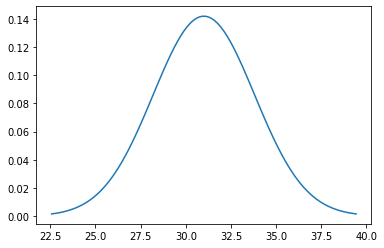

In [38]:
## Tính độ lệch chuẩn
import math 
sigma = math.sqrt(sum_sig)
#print(sigma)

## Vẽ biểu đồ phân phối chuẩn
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import math

mu = time_end
x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(x, stats.norm.pdf(x, mu, sigma))
plt.show()

**Muốn xác định thời gian hoàn thành dự án, chuyển thời gian đó từ phân bố chuẩn sang phân bố Z (ngay gốc tọa độ) rồi tra bảng Z-score**
$$ Z = \frac{D -\mu}{\sqrt{\sigma^2}}$$
<u>Với:</u>
- $D$: giá trị thời gian dự đoán
- $\mu$: giá trị trung bình của phân bố chuẩn
- $\sigma$: độ lệch chuẩn

Vd: Tính xác suất hoàn thành dự án trong 31 ngày

In [39]:
time  = 34
# Chuyển sang phân bố Z
time_z = (time - time_end)/sigma
#print(time_z) 
ss = stats.norm.cdf(time_z)
print(ss)

0.857263084650707
